# New stuff

    - Saving a model
    - Loading a model


# Download the dataset

In [ ]:
!wget https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5

--2023-05-17 08:01:36--  https://www.astro.utoronto.ca/~hleung/shared/Galaxy10/Galaxy10_DECals.h5
Resolving www.astro.utoronto.ca (www.astro.utoronto.ca)... 128.100.89.92
Connecting to www.astro.utoronto.ca (www.astro.utoronto.ca)|128.100.89.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2735267419 (2.5G)
Saving to: ‘Galaxy10_DECals.h5’

100%[====================================>] 2,735,267,419 16.5MB/s   in 2m 49s 

2023-05-17 08:04:26 (15.5 MB/s) - ‘Galaxy10_DECals.h5’ saved [2735267419/2735267419]



# Imports

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.colors import LinearSegmentedColormap
import random
import h5py
import gc
import scipy

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

In [2]:
class_labels = [
    'Disturbed Galaxies',
    'Merging Galaxies',
    'Round Smooth Galaxies',
    'In-between Round Smooth Galaxies',
    'Cigar Shaped Smooth Galaxies',
    'Barred Spiral Galaxies',
    'Unbarred Tight Spiral Galaxies',
    'Unbarred Loose Spiral Galaxies',
    'Edge-on Galaxies without Bulge',
    'Edge-on Galaxies with Bulge'
    ]

In [ ]:
with h5py.File('Galaxy10_DECals.h5', 'r') as dataset:
    images = dataset['images']
    labels = dataset['ans']
    images = np.array(images)
    labels = np.array(labels)

train_img, val_img, train_label, val_label = train_test_split(images, labels, test_size=0.10, random_state=42)

del images; del labels
gc.collect()

del dataset
gc.collect()

0

# Datasets

In [ ]:
class MyDataset(Dataset):
    def __init__(self, img_array, label_array):
        # convert to tensor
        self.img_array   = img_array
        self.label_array = label_array

    def __len__(self):
        return len(self.label_array)

    def __getitem__(self, idx):
        img = torch.tensor(self.img_array[idx] / 255).float()
        img = img.permute(2, 0, 1)
        label = torch.tensor(self.label_array[idx])
        one_hot_label = torch.zeros(10)
        one_hot_label[label.item()] = 1
        return img, label, one_hot_label

In [ ]:
train_ds = MyDataset(train_img, train_label)
del train_img; del train_label
gc.collect()

val_ds   = MyDataset(val_img, val_label)
del val_img; del val_label
gc.collect()

0

# Dataloaders

In [ ]:
train_dl = DataLoader(train_ds, batch_size=250, shuffle=True, num_workers=2)
val_dl   = DataLoader(val_ds, batch_size=5000, shuffle=False, num_workers=2)

# Network**s**

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.seq1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 64, 6),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 1, 1),
            nn.LeakyReLU()
        )

        self.linear = nn.Linear(28*28 + 10, 200)
        self.mean_nn    = nn.Linear(200, 100)
        self.log_var_nn = nn.Linear(200, 100)


    def forward(self, x, label_one_hot):
        x = self.seq1(x)
        x = x.view(-1, 28*28)

        x = torch.cat((x, label_one_hot), dim=1)
        x = nn.ReLU()(self.linear(x))

        mean = self.mean_nn(x)
        log_var = self.log_var_nn(x)
        clipped_log_var = torch.clamp(log_var, min=-10, max=10)

        return mean, clipped_log_var
    

# Decoder
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.linear1 = nn.Linear(100 + 10, 200)
        self.linear2 = nn.Linear(200, 28*28)

        self.seq1 = nn.Sequential(
            nn.ConvTranspose2d(1, 64, kernel_size=1),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 64, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 128, 6),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(128, 128, 2, stride=2),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 5),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(64, 64, 2, stride=2),
            nn.LeakyReLU(),        
            nn.ConvTranspose2d(64, 3, 5),
            nn.Sigmoid()
        )

    def forward(self, x, label_one_hot):
        x = torch.cat((x, label_one_hot), dim=1)

        x = nn.ReLU()(self.linear1(x))
        x = nn.ReLU()(self.linear2(x))

        x = x.view(-1, 1, 28, 28)        

        x = self.seq1(x)
        
        return x

In [4]:
encoder_nn = Encoder()
decoder_nn = Decoder()

if torch.cuda.is_available():
    encoder_nn.cuda()
    decoder_nn.cuda()

In [5]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

In [6]:
print(f'Encoder has {count_parameters(encoder_nn):,} trainable parameters')
print(f'Decoder has {count_parameters(decoder_nn):,} trainable parameters')

Encoder has 704,033 trainable parameters
Decoder has 783,179 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(list(encoder_nn.parameters()) + list(decoder_nn.parameters()), lr=3e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=1000, 
    eta_min=3e-6,
    last_epoch=-1,
    verbose=True)


In [ ]:
def sample(mean, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std, device=mean.device)
    return mean + eps*std

# Saving a torch model

In [ ]:
reco_losses = []
kld_losses  = []
epochs = 200

for ep in tqdm(range(200)):
    reco_tmp_losses = []; kld_tmp_losses = []

    for xb, yb, yb_one_hot in tqdm(train_dl):
        if torch.cuda.is_available():
            xb = xb.cuda()
            yb = yb.cuda()
            yb_one_hot = yb_one_hot.cuda()

        optimizer.zero_grad()
        
        mu, log_var = encoder_nn(xb, yb_one_hot)
        z = sample(mu, log_var)

        pred = decoder_nn(z, yb_one_hot)

        # loss
        reco_loss = F.binary_cross_entropy(pred, xb, reduction='sum')
        kld_loss  = -0.5 * torch.sum(1 + log_var - mu**2 -  log_var.exp())

        loss = reco_loss + 10 * kld_loss

        loss.backward()
        optimizer.step()

        reco_tmp_losses.append(reco_loss.item())
        kld_tmp_losses.append(kld_loss.item())

    reco_losses.append(np.mean(reco_tmp_losses))
    kld_losses.append(np.mean(kld_tmp_losses))

    if ep % 10 == 0:
        torch.save(encoder_nn.state_dict(), f'encoder_{ep}.pth')
        torch.save(decoder_nn.state_dict(), f'decoder_{ep}.pth')
    
    scheduler.step()

    print(f'Epoch {ep+1}/{epochs} | Reco Loss: {reco_losses[-1]:.3f} | KLD Loss: {kld_losses[-1]:.3f}')


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure(figsize=(10, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(reco_losses)
ax.set_title('Reconstruction Loss')

ax = fig.add_subplot(1, 2, 2)
ax.plot(kld_losses)
ax.set_title('KLD Loss')

# Inference from a model that was already trained

In [17]:
def generate_img(checkpoint_path):

    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    decoder_nn.load_state_dict(checkpoint)

    new_z = torch.randn(25, 100)

    new_labels = torch.zeros(25, 10)
    rand_int = torch.randint(0, 10, (25,))
    
    if torch.cuda.is_available():
        new_z = new_z.cuda()
        new_labels = new_labels.cuda()
        rand_int = rand_int.cuda()

    new_labels[torch.arange(25), rand_int] = 1

    new_pred = decoder_nn(new_z, new_labels)
    new_pred = new_pred.cpu().detach().numpy()

    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(5, 5)
    for i in range(25):
        ax = fig.add_subplot(gs[i])
        img_array = new_pred[i].transpose(1, 2, 0)
        ax.imshow(img_array)
        ax.axis('off')
        ax.set_title(class_labels[rand_int[i].item()])

# Get an already trained model

In [12]:
!wget https://www.dropbox.com/s/a6bfjvwdor0a0ck/decoder_910.pth

--2023-05-30 04:10:36--  https://www.dropbox.com/s/a6bfjvwdor0a0ck/decoder_910.pth
Resolving www.dropbox.com (www.dropbox.com)... 162.125.71.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.71.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/a6bfjvwdor0a0ck/decoder_910.pth [following]
--2023-05-30 04:10:36--  https://www.dropbox.com/s/raw/a6bfjvwdor0a0ck/decoder_910.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc7a6539f5820c207b87b33696bd.dl-eu.dropboxusercontent.com/cd/0/inline/B9ASW4mzORRrYk9qkKyBVHnbrjAeYKhWHTUYDKrBI9LmsHnrYgGJbaDUqwB7_Wh6xfJT-EIVsKmr1i93Qfx0UIUVvbMP4445cz8k3TDEnSygTOHVtYlfSED3J38uf2woPUfZLm68MPNt39lMW3UydR6FT-bTgBS3yY_PWQ-fgNcFlw/file# [following]
--2023-05-30 04:10:36--  https://uc7a6539f5820c207b87b33696bd.dl-eu.dropboxusercontent.com/cd/0/inline/B9ASW4mzORRrYk9qkKyBVHnbrjAeYKhWHTUYDKrBI9LmsHnrYgGJbaDUqwB7_W

In [13]:
!ls

 decoder_910.pth  'decoder_910.pth?dl=0'   sample_data


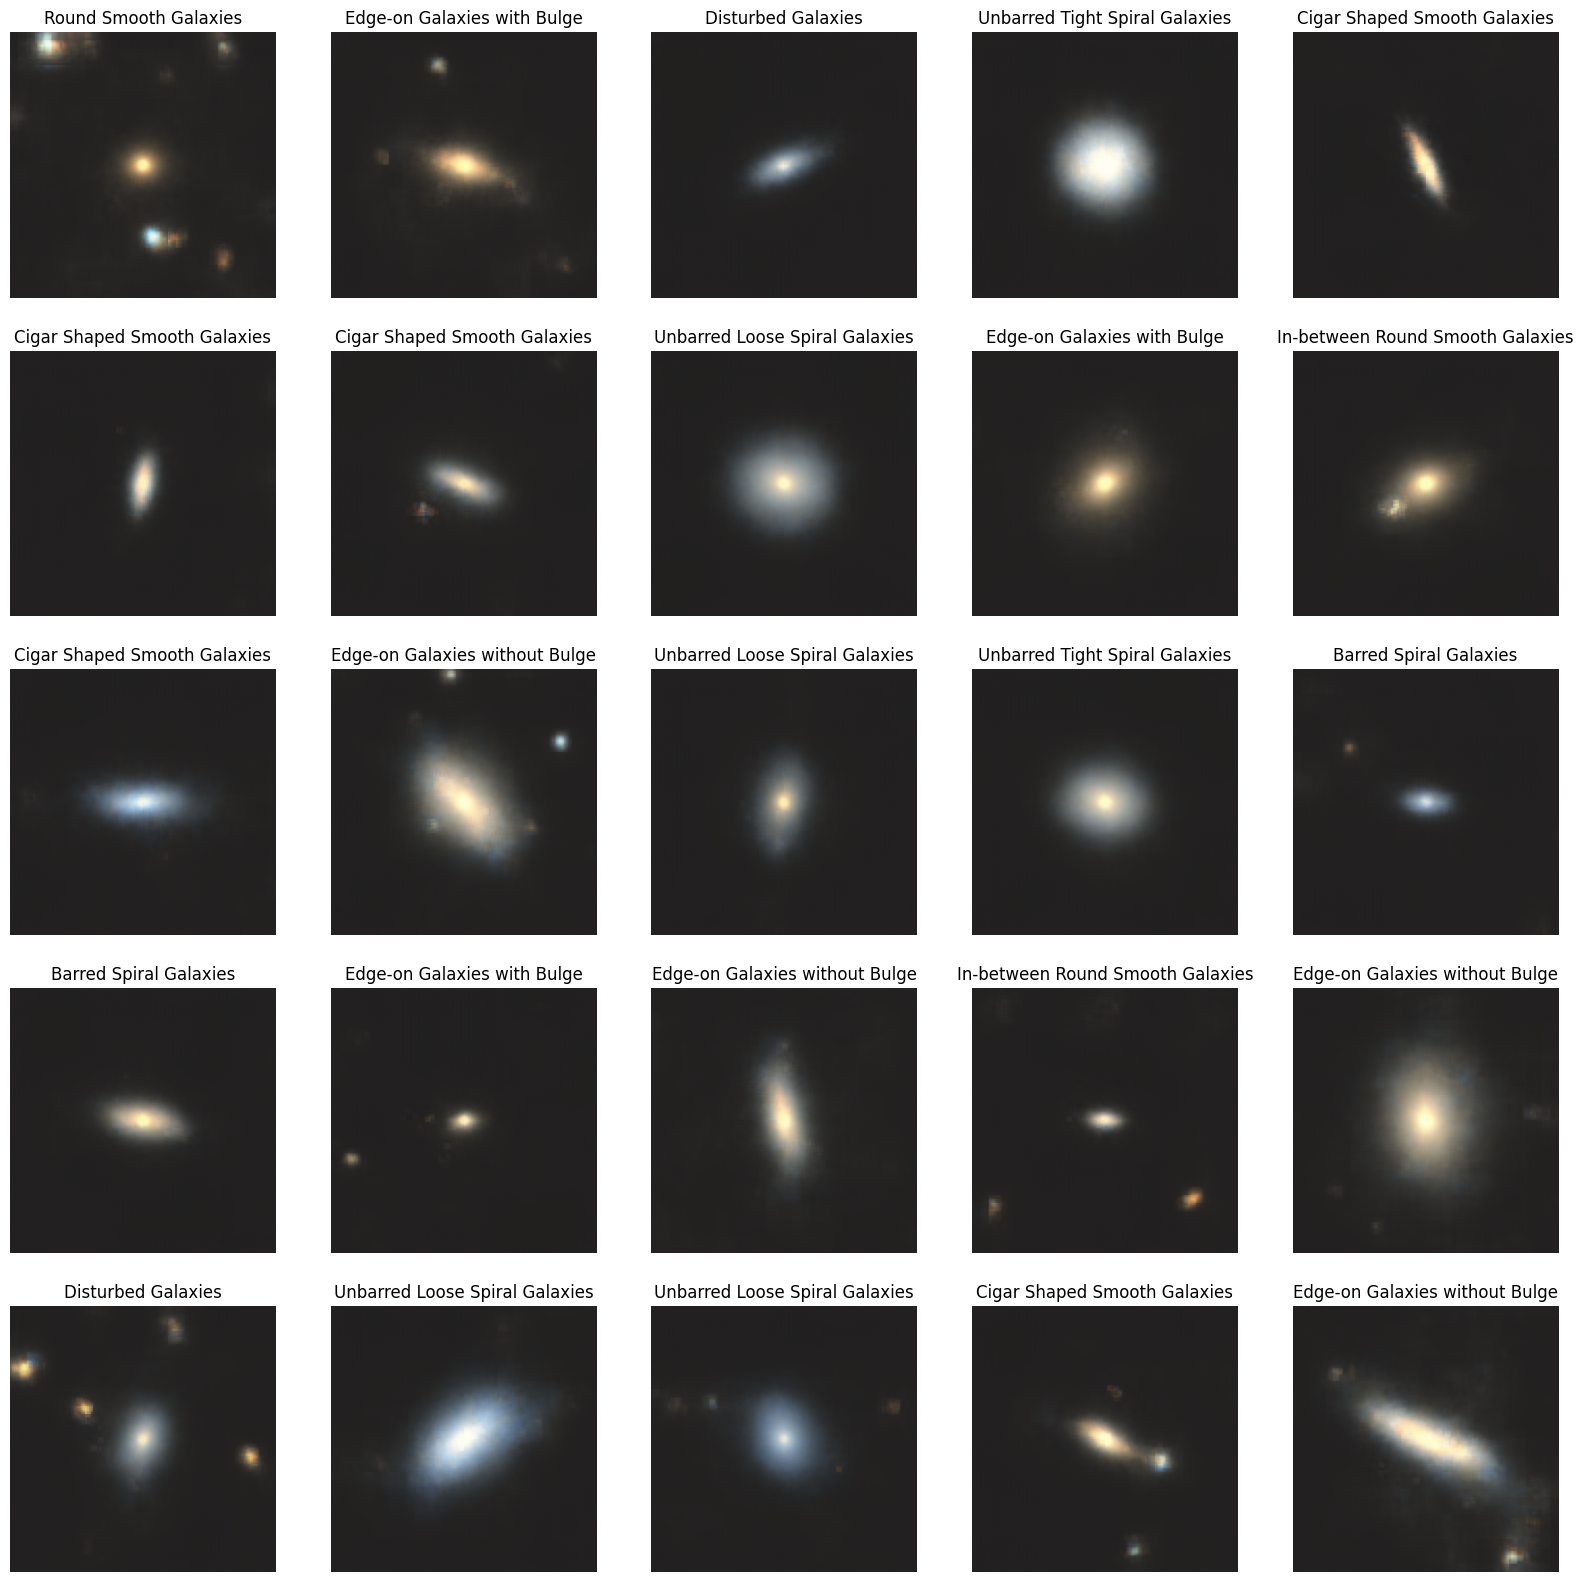

In [18]:
generate_img('decoder_910.pth')